In [1]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generation/")

import torch
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

#plt.style.use("project_style.mplstyle")

import stats
import scipy.stats
from tqdm import tqdm
import analysis_tools as tools

In [2]:
samples = 100
timesteps = 400
sequence  = ["square"]

bins = [16,16]

In [3]:
model_name = "al1_10_l2_0"
path = f"../models/{model_name}"
model, params = tools.load_model(path, device = "cpu", model_type = "RNN")

In [4]:
noise_scales = np.concatenate(([0], np.geomspace(1e-2, 1, 3)))
noise_scales

array([0.  , 0.01, 0.1 , 1.  ])

In [5]:
xa, ra, va, ca = tools.test_dataset(samples*[sequence[0]], timesteps, context = params["context"], 
                                    device = "cpu", trajectories = True)
xb, rb, vb, cb = tools.test_dataset(samples*[sequence[0]], timesteps, context = params["context"], 
                                    device = "cpu", trajectories = True)

In [6]:
def time_ratemaps(states, r, bins):
    # state.shape = (N, T, Nc)
    ratemaps = np.zeros((states.shape[1], states.shape[-1], *bins)).astype("float32")
    for i in range(states.shape[1]):
        ratemaps[i] = stats.ratemaps(states[None,:,i], r[None,:,i], [bins], smooth = True)  
    return ratemaps
        
def autocorr(x):
    z = np.zeros((len(x), len(x)))
    for i in tqdm(range(len(x))):
        for j in range(len(x)):
            z[i, j] = np.corrcoef(x[i], x[j])[1,0]
    return z

In [7]:
noisy_gs = []
noisy_ps = []

relu = torch.nn.ReLU()

for i in tqdm(range(len(noise_scales))):
    g_prev = None
    gs = []
    ps = []
    errors = []
    for x in (xa, xb):
        yhat, g, p, mu = model(x, g_prev = g_prev)
        noise = torch.normal(0, noise_scales[i], size = g[:,-1].shape)
        g_prev = relu(g[:,-1] + noise)
        g_ratemaps = time_ratemaps(g.detach().numpy(), x[1].detach().numpy(), bins)
        p_ratemaps = time_ratemaps(p.detach().numpy(), x[1].detach().numpy(), bins)
        gs.append(g_ratemaps.reshape((g_ratemaps.shape[0], -1)))
        ps.append(p_ratemaps.reshape((p_ratemaps.shape[0], -1)))

    noisy_gs.append(np.concatenate(gs, axis = 0))
    noisy_ps.append(np.concatenate(ps, axis = 0))

100%|██████████| 4/4 [00:52<00:00, 13.17s/it]


In [8]:
noisy_gs = np.array(noisy_gs)
noisy_ps = np.array(noisy_ps)

In [9]:
g_corr = np.zeros((noisy_gs.shape[0], 2*noisy_gs.shape[1] - 1))
p_corr = np.zeros((noisy_ps.shape[0], 2*noisy_ps.shape[1] - 1))
print(g_corr.shape)

(4, 1599)


In [10]:
for i in tqdm(range(len(noise_scales))):
    flipped_g = np.flip(noisy_gs[i], axis=0)
    flipped_p = np.flip(noisy_ps[i], axis=0)
    g_corr[i] = np.sum(scipy.signal.fftconvolve(noisy_gs[i],flipped_g, axes = 0),axis=-1)
    p_corr[i] = np.sum(scipy.signal.fftconvolve(noisy_ps[i],flipped_p, axes = 0),axis=-1)

100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


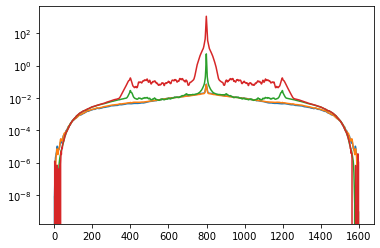

In [18]:
for corr in p_corr:
    plt.semilogy(corr)

In [12]:
def autocorr(x):
    z = np.zeros((len(x), len(x)))
    for i in tqdm(range(len(x))):
        for j in range(len(x)):
            z[i, j] = np.corrcoef(x[i], x[j])[1,0]
    return z

In [13]:
g_corrs = np.zeros((noisy_gs.shape[0], noisy_gs.shape[1],noisy_gs.shape[1]))
p_corrs = np.zeros((noisy_ps.shape[0], noisy_ps.shape[1],noisy_ps.shape[1]))

In [14]:
for i in range(len(noise_scales)):
    g_corrs[i] = autocorr(noisy_gs[i])

100%|██████████| 800/800 [05:21<00:00,  2.49it/s]


In [15]:
for i in range(len(noise_scales)):
    p_corrs[i] = autocorr(noisy_ps[i])

100%|██████████| 800/800 [01:09<00:00, 11.50it/s]


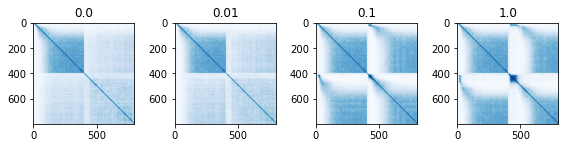

In [16]:
fig, ax = plt.subplots(1, len(noise_scales), figsize = (2*len(noise_scales), 2))
for i in range(len(noise_scales)):
    ax[i].imshow(p_corrs[i], cmap = "Blues")
    ax[i].set_title(noise_scales[i])
plt.tight_layout()

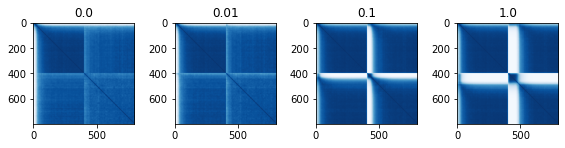

In [17]:
fig, ax = plt.subplots(1, len(noise_scales), figsize = (2*len(noise_scales), 2))
for i in range(len(noise_scales)):
    ax[i].imshow(g_corrs[i], cmap = "Blues")
    ax[i].set_title(noise_scales[i])
plt.tight_layout()